In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler,random_split, ConcatDataset, Subset
from torch import nn, optim
from torch.cuda import amp
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler
import torch.optim.lr_scheduler as lr_scheduler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import shutil

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import random

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:03<00:00, 38.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
# Paths for train, test, and val directories
path = path + '/chest_xray'
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")
val_dir = os.path.join(path, "val")

train_dir, test_dir, val_dir

('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train',
 '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test',
 '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')

In [ ]:
def print_class_counts(directory):
    print(f"Class counts in {directory}:")
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            count = len(os.listdir(class_path))
            print(f"  {class_dir}: {count} files")

In [ ]:
print_class_counts(train_dir)
print_class_counts(test_dir)
print_class_counts(val_dir)

Class counts in /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train:
  NORMAL: 1341 files
  PNEUMONIA: 3875 files
Class counts in /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test:
  NORMAL: 234 files
  PNEUMONIA: 390 files
Class counts in /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val:
  NORMAL: 8 files
  PNEUMONIA: 8 files


In [ ]:
def concat_data(data_path):
  filepaths = []
  labels = []

  folds = os.listdir(data_path)
  for file in folds:
      foldpath = os.path.join(data_path, file)
      filelist = os.listdir(foldpath)

      for f in filelist:
          fpath = os.path.join(foldpath, f)
          filepaths.append(fpath)
          labels.append(file)

  FSeries = pd.Series(filepaths, name='filepaths')
  LSeries = pd.Series(labels, name='label')

  df = pd.concat([FSeries, LSeries], axis=1)
  return df

train_df = concat_data(train_dir)
test_df = concat_data(test_dir)
valid_df = concat_data(val_dir)

In [ ]:
# Combine all data
all_data_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
print(all_data_df['label'].value_counts())

all_data_df

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64


,filepaths,label
0,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
1,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
2,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
3,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
4,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
...,...,...
5851,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5852,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5853,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5854,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA


In [ ]:
# Set up directories
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

normal_df = all_data_df[all_data_df['label'] == 'NORMAL']
print('normal_df shape', normal_df)
normal_image_paths = normal_df['filepaths'].tolist()
augmented_image_dir = '/content/drive/MyDrive/augmented_normal_images_2/NORMAL/'  # Directory where augmented images will be saved
os.makedirs(augmented_image_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Calculate how many augmented images are needed
current_normal_count = len(normal_image_paths)
target_count = 4273  # Count of PNEUMONIA class
required_count = target_count - current_normal_count  # Number of augmented images needed

# Function to augment images
def augment_images(image_paths, required_count, save_dir):
    augmented_count = 0
    print(f"Starting augmentation. Need {required_count} augmented images.")

    # Loop over images and augment them
    while augmented_count < required_count:
        # Pick a random image from the "NORMAL" images
        img_path = random.choice(image_paths)
        img = load_img(img_path)  # Load the image
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # Reshape for ImageDataGenerator

        # Generate augmented images and save them
        for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='normal', save_format='jpeg'):
            augmented_count += 1
            if augmented_count >= required_count:
                break  # Stop when we've generated enough images
    print(f"Augmented {augmented_count} images. The NORMAL class now has {current_normal_count + augmented_count} images.")

augment_images(normal_image_paths, required_count, augmented_image_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
normal_df shape                                               filepaths   label
0     /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
1     /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
2     /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
3     /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
4     /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
...                                                 ...     ...
5843  /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
5844  /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
5845  /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
5846  /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL
5847  /root/.cache/kagglehub/datasets/paultimothymoo...  NORMAL

[1583 rows x 2 columns]
Starting augmentation. Need 2690 augmented images.
Augmented 2

In [ ]:
# load augmented data for NORMAL class

normal_aug_df = concat_data('/content/drive/MyDrive/augmented_normal_images_2/')
normal_aug_df

,filepaths,label
0,/content/drive/MyDrive/augmented_normal_images...,NORMAL
1,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2,/content/drive/MyDrive/augmented_normal_images...,NORMAL
3,/content/drive/MyDrive/augmented_normal_images...,NORMAL
4,/content/drive/MyDrive/augmented_normal_images...,NORMAL
...,...,...
2685,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2686,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2687,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2688,/content/drive/MyDrive/augmented_normal_images...,NORMAL


In [ ]:
# Combine all data
all_data_df = pd.concat([train_df, test_df, valid_df, normal_aug_df], ignore_index=True)
print(all_data_df['label'].value_counts())

all_data_df

label
NORMAL       4273
PNEUMONIA    4273
Name: count, dtype: int64


,filepaths,label
0,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
1,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
2,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
3,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
4,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
...,...,...
8541,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8542,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8543,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8544,/content/drive/MyDrive/augmented_normal_images...,NORMAL


In [ ]:
# Split into training (70%) and remaining (30%) for validation and test
train_df, remaining_df = train_test_split(all_data_df, test_size=0.3, stratify=all_data_df['label'], random_state=42)

# Split remaining data into validation (50% of remaining) and test (50% of remaining)
valid_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['label'], random_state=42)

print(f"Train label distribution:\n{train_df['label'].value_counts()}")
print(f"Validation label distribution:\n{valid_df['label'].value_counts()}")
print(f"Test label distribution:\n{test_df['label'].value_counts()}")

Train label distribution:
label
NORMAL       2991
PNEUMONIA    2991
Name: count, dtype: int64
Validation label distribution:
label
NORMAL       641
PNEUMONIA    641
Name: count, dtype: int64
Test label distribution:
label
PNEUMONIA    641
NORMAL       641
Name: count, dtype: int64


In [ ]:
batch_size = 16
img_size = (224, 224)

# Define ImageDataGenerators with the new image size and batch size
data_gen = ImageDataGenerator(
    rescale=1./255
)

# Flow from the dataframes
train_gen = data_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='label',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = data_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='label',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen = data_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='label',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)


Found 5982 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.


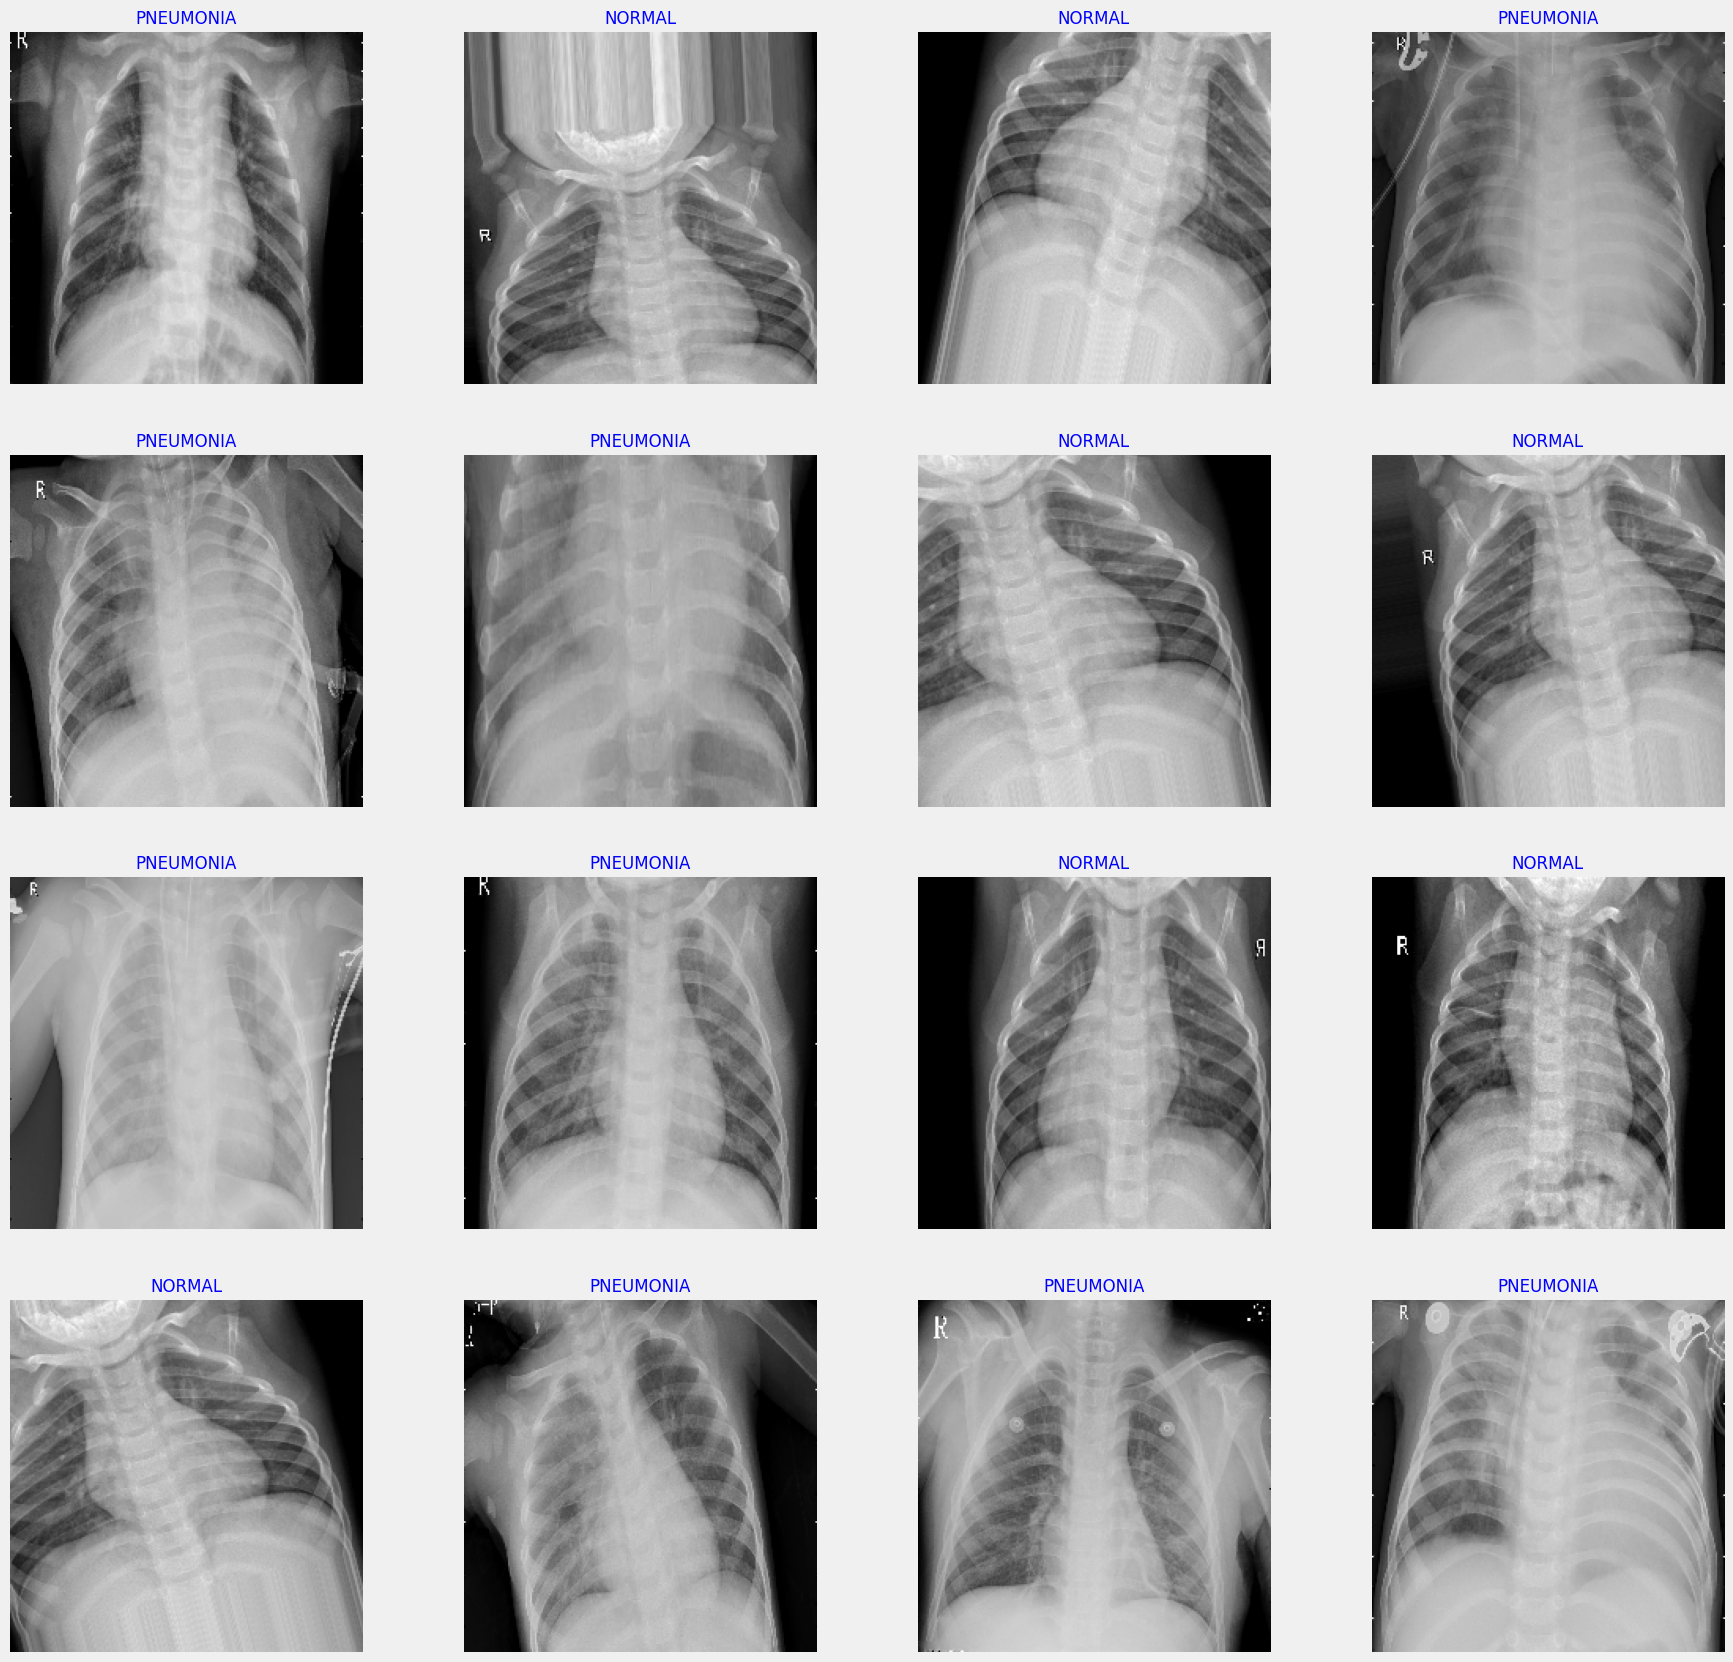

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
epochs = 5

from datetime import datetime
print('start', datetime.now())
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)
print('end', datetime.now())

start 2024-12-18 11:31:01.919171
Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 87s 211ms/step - accuracy: 0.8897 - loss: 0.4467 - val_accuracy: 0.9555 - val_loss: 0.2615
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.9499 - loss: 0.2707 - val_accuracy: 0.9563 - val_loss: 0.2341
Epoch 3/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 70s 187ms/step - accuracy: 0.9574 - loss: 0.2235 - val_accuracy: 0.9649 - val_loss: 0.2027
Epoch 4/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 71s 191ms/step - accuracy: 0.9610 - loss: 0.2099 - val_accuracy: 0.9649 - val_loss: 0.1968
Epoch 5/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 212ms/step - accuracy: 0.9666 - loss: 0.1928 - val_accuracy: 0.9657 - val_loss: 0.1852
end 2024-12-18 11:37:21.008921


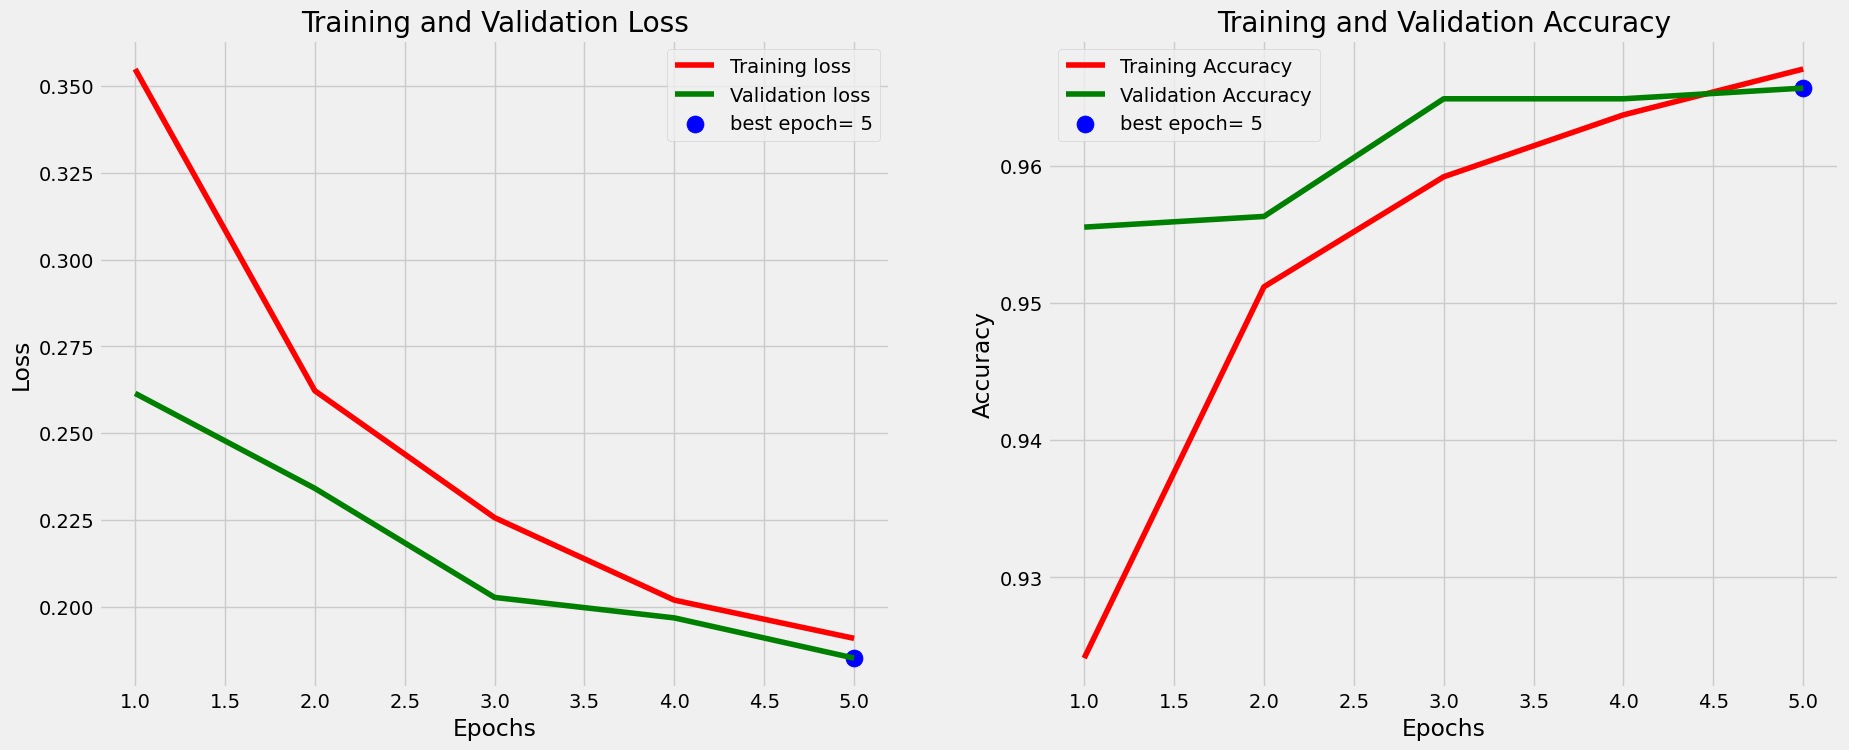

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - accuracy: 0.9758 - loss: 0.1628
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.9711 - loss: 0.1684
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.9784 - loss: 0.1575
Train Loss:  0.1590268909931183
Train Accuracy:  0.976262092590332
--------------------
Validation Loss:  0.17013834416866302
Validation Accuracy:  0.9711388349533081
--------------------
Test Loss:  0.15954749286174774
Test Accuracy:  0.9765990376472473


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm

81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step


array([[622,  19],
       [ 11, 630]])

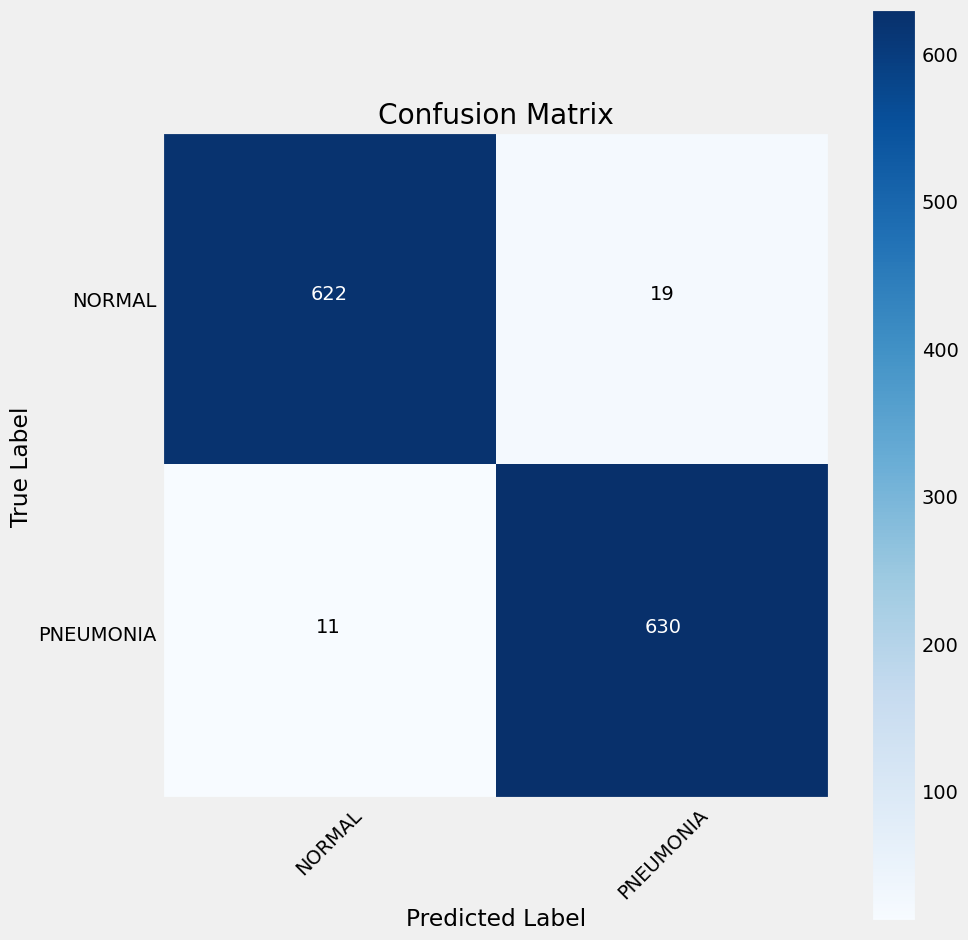

In [ ]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.grid(False)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.98      0.97      0.98       641
   PNEUMONIA       0.97      0.98      0.98       641

    accuracy                           0.98      1282
   macro avg       0.98      0.98      0.98      1282
weighted avg       0.98      0.98      0.98      1282



In [ ]:
# After training the model, save the model to a specified path

model.save('/content/drive/MyDrive/modelsaved/mobilenetv2_model.h5')
